In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from coremdlr.datasets import WellLoader, FaciesDataset
from coremdlr.models import FeaturePredictor, LambdaModel

Using TensorFlow backend.


In [2]:
fdset = FaciesDataset(["205-21b-3", "204-24a-6", "204-20-6a"],
                    test_wells=["204-19-6"],
                    features=["pseudoGR"],
                    label_resolution=32)

fdset.load_or_generate_data()

Loading Well:  205-21b-3


/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/well_loader.py:24: RuntimeWarning: Mean of empty slice
  pseudoGR = np.apply_along_axis(lambda x: np.nanmean(x[x.nonzero()]), 1, uimg)


Feature shapes:  [('depth', (3843,)), ('pseudoGR', (3843, 32))]
Loading Well:  204-24a-6
Feature shapes:  [('depth', (13012,)), ('pseudoGR', (13012, 32))]
Loading Well:  204-20-6a
Feature shapes:  [('depth', (3877,)), ('pseudoGR', (3877, 32))]
Loading Well:  204-19-6
Feature shapes:  [('depth', (1882,)), ('pseudoGR', (1882, 32))]


In [3]:
import hyperopt
from hyperopt import hp
from hyperopt.pyll.base import scope
from sklearn.metrics import f1_score, log_loss
from sklearn.utils.class_weight import compute_sample_weight

from scipy.stats import mstats


# for balanced log_loss computation
sample_weights = compute_sample_weight('balanced', fdset.y_test) 

# feat_names = ['mean', 'median', 'hmean', 'gmean', 'var', 'IF_0', 'IF_1', 'Chi2', 'p-val']
feat_names = ['mean', 'median', 'hmean', 'gmean', 'var', 'IF_0', 'IF_1']

def reduce_function(x):
    feats = []
    x = np.ma.masked_invalid(x)
    x = np.ma.masked_less_equal(x, 0.0)
    feats.append(np.mean(x, axis=-1))
    feats.append(np.median(x, axis=-1))
    feats.append(mstats.hmean(x, axis=-1))
    feats.append(mstats.gmean(x, axis=-1))
    feats.append(np.var(x, axis=-1))
    
    # feats.append(sp.signal.qspline1d(x))
    ideal_fourths = mstats.idealfourths(x, axis=-1)
    feats.append(ideal_fourths[:, 0])
    feats.append(ideal_fourths[:, 1])
    
    print(x.shape)
    
    #normal_test = mstats.normaltest(x, axis=1)
    #feats.append(normal_test[0])
    #feats.append(normal_test[1])
    # kur_test = mstats.kurtosistest(x, axis =-1)
    # feats.append(kurtosistest[:, 0])
    # feats.append(kurtosistest[:, 1])
    
    x_feats = np.array(feats).T
    return x_feats


feat_model_args = {
    # NOTE: key needs to be feature name AND feature must be specified in model_args
    'pseudoGR': {
        'model' : 'LambdaModel',
        'model_args' : {
            'feature' : 'pseudoGR',
            'lambda_fn' : reduce_function
        }
    }
}

XGB_SEARCH_SPACE = {
    'model_type' : 'XGB',
    'max_depth' : scope.int(hp.quniform('max_depth', 3, 10, 1)),
    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2),
    'n_estimators' : scope.int(hp.quniform('n_estimators', 10, 1000, 1)),
    'objective' : 'multi:softprob',
    'n_jobs' : 2,
    'gamma' : hp.uniform('gamma', 0, 0.5),
    'subsample' : hp.uniform('subsample', 0.3, 1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.3, 1.0),
    'colsample_bylevel' : 1,
    'reg_alpha' : 0,                                    # L1 penalty
    'reg_lambda' : hp.uniform('reg_lambda', 0.1, 10),   # L2 penalty
    'tree_method' : 'gpu_exact',
}

def train_xgb_model(model_config):
    xgb_predictor = FeaturePredictor(fdset, 
                                     model_args=model_config, 
                                     feature_model_args=feat_model_args)
    test_acc = xgb_predictor.fit(fdset, verbose=False)
    y_pred = xgb_predictor.predict(fdset.X_test)
    print('F1 score:', f1_score(fdset.y_test, y_pred, average='macro'))
    return log_loss(fdset.y_test, xgb_predictor.predict_proba(fdset.X_test))

In [4]:
'''
best_params = hyperopt.fmin(
    fn=train_xgb_model,
    space=XGB_SEARCH_SPACE,
    algo=hyperopt.rand.suggest,
    max_evals=50
)
'''

'\nbest_params = hyperopt.fmin(\n    fn=train_xgb_model,\n    space=XGB_SEARCH_SPACE,\n    algo=hyperopt.rand.suggest,\n    max_evals=50\n)\n'

In [5]:
best_params = {
 'colsample_bytree': 0.46239341232206516,
 'gamma': 0.21223516841549367,
 'learning_rate': 0.15065028276987713,
 'max_depth': 4,
 'n_estimators': 242,
 'reg_lambda': 6.187153073660272,
 'subsample': 0.3641229800274667
}

Training model for feature:  pseudoGR


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


(20732, 32)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(1882, 32)
                      precision    recall  f1-score   support

           sandstone       0.77      0.82      0.79       981
clay-prone sandstone       0.02      0.00      0.01       222
      sandy mudstone       0.29      0.44      0.35       263
            mudstone       0.64      0.59      0.62       416

         avg / total       0.59      0.62      0.60      1882

Total accuracy Score :  0.6200850159404888
Confusion Matrix: 
 [[803  14 120  44]
 [149   1  51  21]
 [ 60  14 116  73]
 [ 28  22 119 247]]
(1882, 32)


/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[477 100 981 222 263 416]
[ 477  100 1040   51  406  385]


(<Figure size 1080x18000 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f19ee67d8d0>,
       dtype=object))

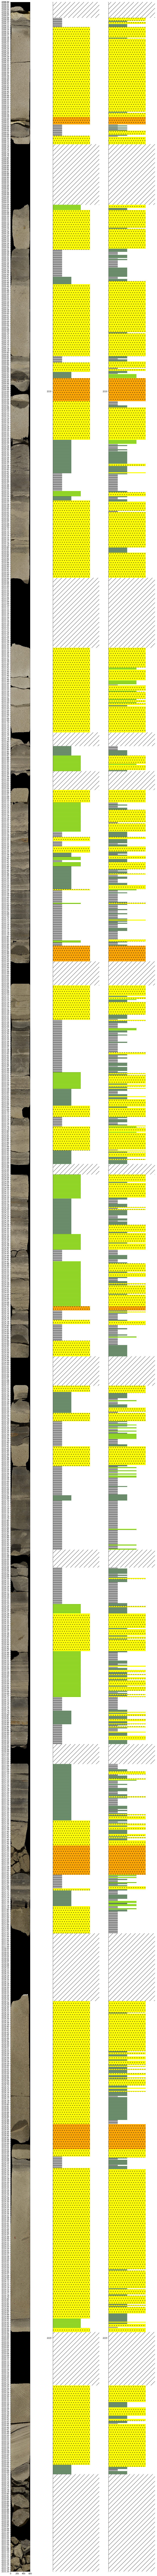

In [6]:
params = {**XGB_SEARCH_SPACE, **best_params}

xgb_predictor = FeaturePredictor(fdset, model_args=params, feature_model_args=feat_model_args)

xgb_predictor.fit(fdset, verbose=True)

fig, ax = xgb_predictor.plot_preds("204-19-6", figsize=(15,250))

plt.show()

#plt.savefig('foo.pdf')

In [7]:
plt.show()